In [1]:
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

In [2]:
df = pd.read_csv('/content/DataExport_2024-01-08_18-08-33.csv', delimiter=';')
df.head()

,Дата,Смертей за день,Заражений за день,Выздоровлений за день
0,12.03.2020,0,21,0
1,13.03.2020,0,5,0
2,14.03.2020,0,9,0
3,15.03.2020,0,0,1
4,16.03.2020,0,18,0


In [3]:
df['Дата'] = pd.to_datetime(df['Дата'])
df['Заражений за день']

<ipython-input-3-e09663964bbc>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Дата'] = pd.to_datetime(df['Дата'])


0         21
1          5
2          9
3          0
4         18
        ... 
1033     793
1034    1123
1035    1678
1036    1539
1037    1728
Name: Заражений за день, Length: 1038, dtype: int64

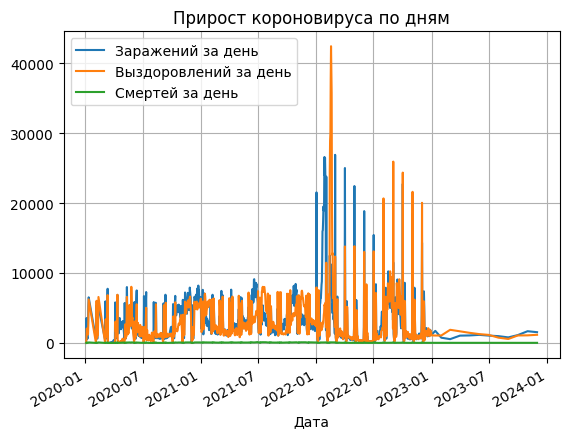

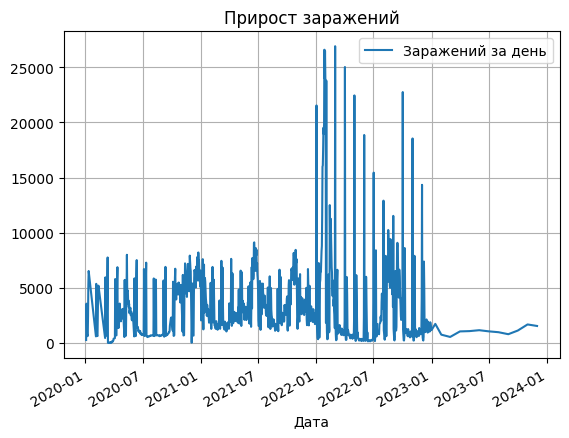

In [4]:
df.plot(x='Дата',
        y=['Заражений за день', 'Выздоровлений за день', 'Смертей за день'],
        title='Прирост короновируса по дням')
plt.grid()
df.plot(x='Дата', y='Заражений за день', title='Прирост заражений')
plt.grid()
plt.show()

## Нахождение частоты дискретизации

In [5]:
t_d = np.mean(np.diff(df['Дата'])) / np.timedelta64(
    1, 's')
t_d

64237.608486017

In [6]:
data_sec = []
for i in range(df.shape[0]):
      data_sec.append(i*t_d)
f_d = 1/t_d
print ('Количество диапазонов с частотой дискретизации', round(f_d, 8) , 'сек -', len(data_sec))

Количество диапазонов с частотой дискретизации 1.557e-05 сек - 1038


In [7]:
df['seconds'] = data_sec

## Применим прямое Фурье преобразование для получения спектра

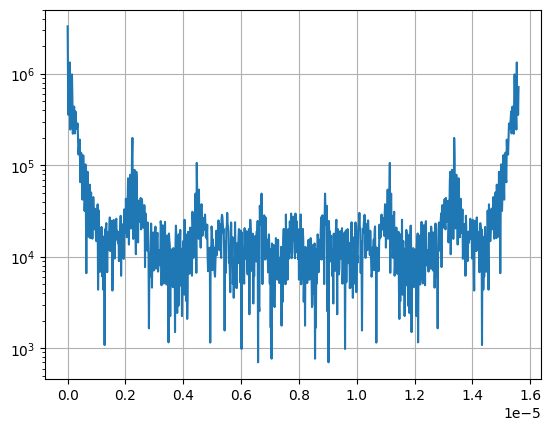

In [8]:
t_new = [i*t_d for i in range (int(max(data_sec)//t_d))]
df_fourier = np.fft.fft(df['Заражений за день'])
fr = [i/t_new[-1] for i in range(len(df['Заражений за день']))]
plt.figure()
plt.semilogy(fr, abs(df_fourier))
plt.grid()

## Выделение части спектра

Симметричность спектра позволяет взять его половину

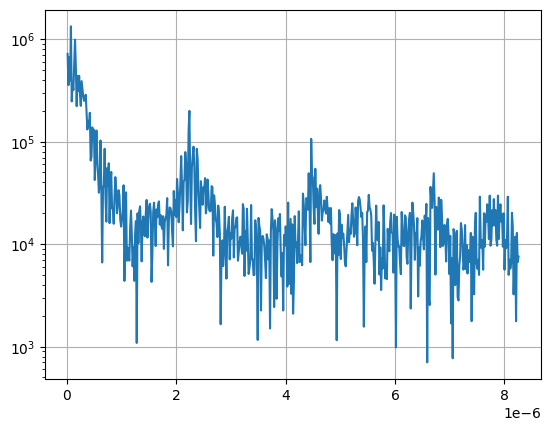

In [9]:
plt.semilogy(fr[1:550], abs(df_fourier)[1:550])
plt.grid()

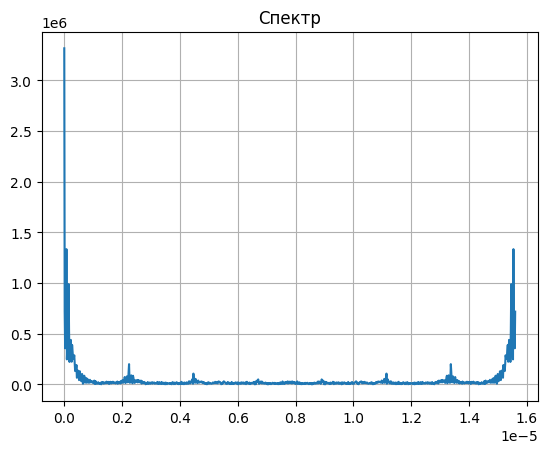

In [10]:
peaks = find_peaks(fr)
plt.figure()
plt.plot(fr, abs(df_fourier))
plt.title('Спектр')
plt.grid()

In [11]:
df['fourier'] = abs(df_fourier)
df

,Дата,Смертей за день,Заражений за день,Выздоровлений за день,seconds,fourier
0,2020-12-03,0,21,0,0.000000e+00,3.315021e+06
1,2020-03-13,0,5,0,6.423761e+04,7.175895e+05
2,2020-03-14,0,9,0,1.284752e+05,3.560367e+05
3,2020-03-15,0,0,1,1.927128e+05,6.638150e+05
4,2020-03-16,0,18,0,2.569504e+05,3.949229e+05
...,...,...,...,...,...,...
1033,2023-09-01,15,793,569,6.635745e+07,1.333930e+06
1034,2023-10-01,16,1123,1069,6.642169e+07,3.949229e+05
1035,2023-11-01,14,1678,1087,6.648592e+07,6.638150e+05
1036,2023-12-01,15,1539,1166,6.655016e+07,3.560367e+05


Пики на спектре

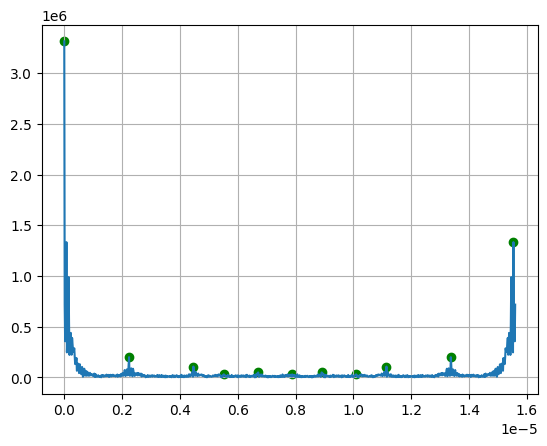

In [12]:
n = 50
df['local_max_fourier'] = df.iloc[argrelextrema(df.fourier.values,
                                                np.greater_equal,
                                                order=n)[0]]['fourier']
plt.plot(fr, abs(df_fourier))
plt.scatter(fr, df['local_max_fourier'], c='g')
plt.grid()

In [13]:
df['fr'] = fr
freq_of_fluc = df[abs(df_fourier) == df['local_max_fourier']].copy()
freq_of_fluc.index = np.arange(len(freq_of_fluc))
freq_of_fluc

,Дата,Смертей за день,Заражений за день,Выздоровлений за день,seconds,fourier,local_max_fourier,fr
0,2020-12-03,0,21,0,0.000000e+00,3.315021e+06,3.315021e+06,0.000000
1,2020-08-08,14,691,1278,9.571404e+06,1.995471e+05,1.995471e+05,0.000002
2,2021-03-01,77,3851,6114,1.907857e+07,1.064081e+05,1.064081e+05,0.000004
3,2021-03-14,55,1905,1110,2.357520e+07,3.025624e+04,3.025624e+04,0.000006
4,2021-01-06,62,3669,2393,2.864997e+07,4.915293e+04,4.915293e+04,0.000007
5,2021-08-18,59,1590,3029,3.366051e+07,2.972155e+04,2.972155e+04,0.000008
6,2021-10-25,83,7778,3892,3.802866e+07,4.915293e+04,4.915293e+04,0.000009
7,2022-12-01,66,4008,2826,4.310344e+07,3.025624e+04,3.025624e+04,0.000010
8,2022-03-23,28,1306,1262,4.760007e+07,1.064081e+05,1.064081e+05,0.000011
9,2022-08-18,17,9080,7355,5.710723e+07,1.995471e+05,1.995471e+05,0.000013


In [14]:
l = []
for i in range(0, len(freq_of_fluc) - 1):
    r = freq_of_fluc.fr[i + 1] - freq_of_fluc.fr[i]
    l.append(r)
l = np.array(l)
days = (1 / (l * 3600 * 24))
print(np.round(days, 2))

[ 5.16  5.2  10.99  9.74  9.87 11.32  9.74 10.99  5.2   5.34]


Периодичность примерно равна одной недели

Локальные максимумы исходного графика

In [15]:
df['data'] = df['Заражений за день']
df['max'] = df.iloc[argrelextrema(df.data.values, np.greater_equal,
                                  order=n)[0]]['data']

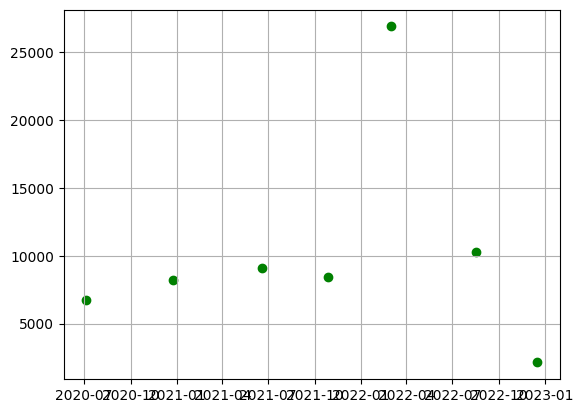

In [22]:
plt.scatter(df['Дата'], df['max'], c='g')
plt.grid()

In [ ]:
df['max_NaN'] = np.where(df['max'].isnull(), 0, 1)
print('Даты, соответствующие наивысшим точкам каждой волны заболеваемости:\n')
df = df[df['max_NaN'] != 0]
df['Дата']

Даты, соответствующие наивысшим точкам каждой волны заболеваемости:



60     2020-05-11
287    2020-12-24
484    2021-07-09
604    2021-11-06
701    2022-02-11
918    2022-09-16
1009   2022-12-16
Name: Дата, dtype: datetime64[ns]

## Вывод

В ходе работы была оценена высокочастотная периодичность прироста новых случаев заболевания короновирусом.  Высокочастотная периодичность прироста новых случаев заболевания имеет периуд примерно раыный одной неделе, что может быть связанно с поовышенной численностью людей в местах их скопления в выходные дни.
Даты, соответствующие наивысшим точкам каждой волны заболеваемости в основном соответствуют осенним и зимним сезонам, во время которых происходит снижение уровня имунитета.